In [78]:
# importing built-in libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# importing non-linear optics library
import pynlo
from pynlo.interactions.FourWaveMixing import SSFM
from pynlo.media.fibers import fiber
from pynlo.media.waveguides import waveguide
from pynlo.light.DerivedPulses import SechPulse, GaussianPulse

In [79]:
# setting up parameters

FWHM    = 0.20  # pulse duration (ps)
pulseWL = 1562.6   # pulse central wavelength (nm)
EPP     = 2e-10 # Energy per pulse (J)
GDD     = 0.0    # Group delay dispersion (ps^2)
TOD     = 0.0    # Third order dispersion (ps^3)

Window  = 10.0   # simulation window (ps)
Steps   = 100    # simulation steps
Points  = 2**13  # simulation points

beta2   = -120     # (ps^2/km)
beta3   = 0.00     # (ps^3/km)
beta4   = 0.005    # (ps^4/km)

Length  = 21.05    # length in mm
# thickness = 750  # thikness in nm
# width = 2100     # width in nm

Alpha   = -2.0     # attentuation coefficient (dB/cm)
Gamma   = 1000    # Gamma (1/(W km)

fibWL   = pulseWL # Center WL of fiber (nm)

Raman   = True    # Enable Raman effect?
Steep   = True    # Enable self steepening?

alpha = np.log((10**(Alpha * 0.1))) * 100  # convert from dB/cm to 1/m

## Plotting 200fs pulse through fiber 

<IPython.core.display.Javascript object>


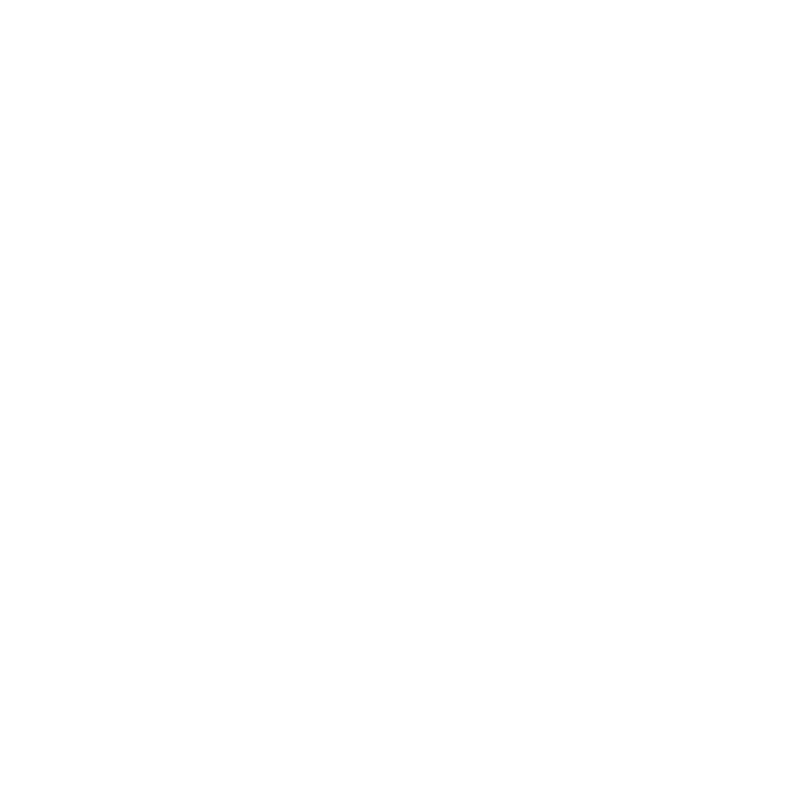

Pulse energy before Simple Fiber : 0.20000000000000004 nJ
pulse energy in  7561.404354011291
copied as   7561.404354011291
Step: 0 Distance remaining: 0.021050000000000003
Pulse energy after: 0.20078812790734415 nJ
Step: 1 Distance remaining: 0.020839500000000004
Pulse energy after: 0.20274045150299974 nJ
Step: 2 Distance remaining: 0.020629
Pulse energy after: 0.20471093523634415 nJ
Step: 3 Distance remaining: 0.020418500000000003
Pulse energy after: 0.20669971827743108 nJ
Step: 4 Distance remaining: 0.020208
Pulse energy after: 0.20870693460891973 nJ
Step: 5 Distance remaining: 0.0199975
Pulse energy after: 0.2107327123780189 nJ
Step: 6 Distance remaining: 0.019787000000000003
Pulse energy after: 0.21277717318659348 nJ
Step: 7 Distance remaining: 0.0195765
Pulse energy after: 0.2148404313600889 nJ
Step: 8 Distance remaining: 0.019366000000000005
Pulse energy after: 0.21692259336391523 nJ
Step: 9 Distance remaining: 0.019155500000000002
Pulse energy after: 0.21902375566617022 nJ
Step:

Pulse energy after: 0.49821956349601015 nJ
Step: 95 Distance remaining: 0.0010525000000000011
Pulse energy after: 0.5032580790246263 nJ
Step: 96 Distance remaining: 0.0008420000000000008
Pulse energy after: 0.5081166619368671 nJ
Step: 97 Distance remaining: 0.0006315000000000007
Pulse energy after: 0.513042835093415 nJ
Step: 98 Distance remaining: 0.0004210000000000004
Pulse energy after: 0.5180349087651552 nJ
Step: 99 Distance remaining: 0.0002105000000000002
Pulse energy after: 0.5230272086971848 nJ
Pulse energy after Simple Fiber : 0.5231482625660564 nJ


C:\Users\PallaviPunj\AppData\Local\Temp\ipykernel_5956\3031857067.py:42: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(np.abs(num)**2)


In [80]:
# set up plots for the results:

fig = plt.figure(figsize=(8,8))
ax0 = plt.subplot2grid((3,2), (0, 0), rowspan=1)
ax1 = plt.subplot2grid((3,2), (0, 1), rowspan=1)
ax2 = plt.subplot2grid((3,2), (1, 0), rowspan=2, sharex=ax0)
ax3 = plt.subplot2grid((3,2), (1, 1), rowspan=2, sharex=ax1)


######## This is where the PyNLO magic happens! ############################

# create the pulse!
pulse = pynlo.light.DerivedPulses.GaussianPulse(power = 1, # Power will be scaled by set_epp
                                            T0_ps                   = FWHM,
                                            center_wavelength_nm    = pulseWL,
                                            time_window_ps          = Window,
                                            GDD=GDD, TOD=TOD,
                                            NPTS            = Points,
                                            frep_MHz        = 100,
                                            power_is_avg    = False)
# set the pulse energy!
pulse.set_epp(EPP)

# create the fiber!
fiber1 = pynlo.media.fibers.fiber.FiberInstance()
fiber1.generate_fiber(Length * 1e-3, center_wl_nm=fibWL, betas=(beta2, beta3, beta4),
                              gamma_W_m=Gamma * 1e-3, gvd_units='ps^n/km', gain=-alpha)

# Propagation
evol = pynlo.interactions.FourWaveMixing.SSFM.SSFM(local_error=0.005, USE_SIMPLE_RAMAN=True,
                 disable_Raman              = np.logical_not(Raman),
                 disable_self_steepening    = np.logical_not(Steep))

y, AW, AT, pulse_out = evol.propagate(pulse_in=pulse, fiber=fiber1, n_steps=Steps)

########## That's it! Physics complete. Just plotting commands from here! ################


F = pulse.wl_nm     # Wavelength grid of pulse (nm)

def dB(num):
    return 10 * np.log10(np.abs(num)**2)

zW = dB( np.transpose(AW)[:, (F > 0)] )
zT = dB( np.transpose(AT) )

y_mm = y * 1e3 # convert distance to mm

ax0.plot(pulse_out.wl_nm,    dB(pulse_out.AW),  color = 'r')
ax1.plot(pulse_out.T_ps,     dB(pulse_out.AT),  color = 'r')

ax0.plot(pulse.wl_nm,    dB(pulse.AW),  color = 'b')
ax1.plot(pulse.T_ps,     dB(pulse.AT),  color = 'b')

extent = (np.min(F[F > 0]), np.max(F[F > 0]), 0, Length)
ax2.imshow(zW, extent=extent,
           vmin=np.max(zW) - 40.0, vmax=np.max(zW),
           aspect='auto', origin='lower')

extent = (np.min(pulse.T_ps), np.max(pulse.T_ps), np.min(y_mm), Length)
ax3.imshow(zT, extent=extent,
           vmin=np.max(zT) - 40.0, vmax=np.max(zT),
           aspect='auto', origin='lower')


ax0.set_ylabel('Intensity (dB)')
ax0.set_ylim( - 80,  0)
ax1.set_ylim( - 40, 40)

ax2.set_ylabel('Propagation distance (mm)')
ax2.set_xlabel('Wavelength (nm)')
ax2.set_xlim(400,1800)

ax3.set_xlabel('Time (ps)')

plt.show()

In [65]:
%matplotlib notebook

<IPython.core.display.Javascript object>


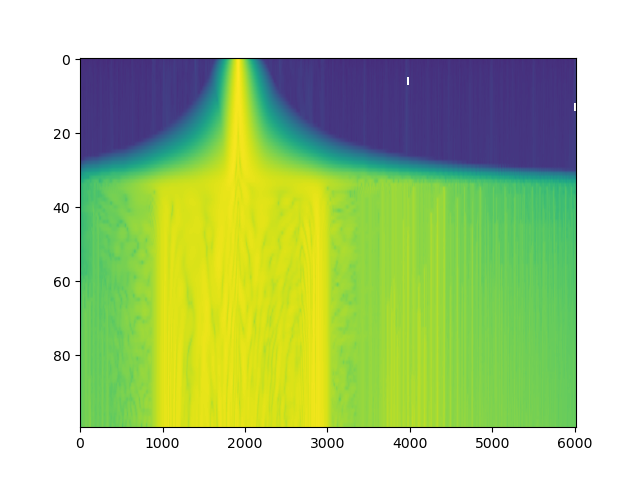

In [81]:
plt.close()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(zW)
ax.set_aspect('auto')
plt.show()

## Plotting 200fs through waveguide

In [ ]:
# setting up parameters

FWHM    = 0.20  # pulse duration (ps)
pulseWL = 1562.6   # pulse central wavelength (nm)
EPP     = 2e-10 # Energy per pulse (J)
GDD     = 0.0    # Group delay dispersion (ps^2)
TOD     = 0.0    # Third order dispersion (ps^3)

Window  = 10.0   # simulation window (ps)
Steps   = 100    # simulation steps
Points  = 2**13  # simulation points

beta2   = -120     # (ps^2/km)
beta3   = 0.00     # (ps^3/km)
beta4   = 0.005    # (ps^4/km)

Length  = 21.05    # length in mm
# thickness = 750  # thikness in nm
# width = 2100     # width in nm

Alpha   = -2.0     # attentuation coefficient (dB/cm)
Gamma   = 1000    # Gamma (1/(W km)

fibWL   = pulseWL # Center WL of fiber (nm)

Raman   = True    # Enable Raman effect?
Steep   = True    # Enable self steepening?

alpha = np.log((10**(Alpha * 0.1))) * 100  # convert from dB/cm to 1/m

In [ ]:
# set up plots for the results:

fig = plt.figure(figsize=(8,8))
ax0 = plt.subplot2grid((3,2), (0, 0), rowspan=1)
ax1 = plt.subplot2grid((3,2), (0, 1), rowspan=1)
ax2 = plt.subplot2grid((3,2), (1, 0), rowspan=2, sharex=ax0)
ax3 = plt.subplot2grid((3,2), (1, 1), rowspan=2, sharex=ax1)


######## This is where the PyNLO magic happens! ############################

# create the pulse!
pulse = pynlo.light.DerivedPulses.GaussianPulse(power = 1, # Power will be scaled by set_epp
                                            T0_ps                   = FWHM,
                                            center_wavelength_nm    = pulseWL,
                                            time_window_ps          = Window,
                                            GDD=GDD, TOD=TOD,
                                            NPTS            = Points,
                                            frep_MHz        = 100,
                                            power_is_avg    = False)
# set the pulse energy!
pulse.set_epp(EPP)

# create the waveguide
waveguide1 = pynlo.media.waveguides.waveguide.WaveguideInstance()
waveguide1.generate_waveguide(Length *1e-3, Width, Thickness, center_wl_nm=fibWL, betas=(beta2, beta3, beta4), 
                              gamma_W_m= Gamma * 1e-3, gvd_units='ps^n/km',gain=-alpha)

# Propagation
evol = pynlo.interactions.FourWaveMixing.SSFM.SSFM(local_error=0.005, USE_SIMPLE_RAMAN=True,
                 disable_Raman              = np.logical_not(Raman),
                 disable_self_steepening    = np.logical_not(Steep))

y, AW, AT, pulse_out = evol.propagate(pulse_in=pulse, waveguide=waveguide1, n_steps=Steps)